# Лабораторная работа №6
## Применение сверточных нейронных сетей (многоклассовая классификация)


In [10]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
import os
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import vgg16
from sklearn import metrics

IMAGE_SIZE = 300
BATCH_SIZE = 50
EPOCHS = 50

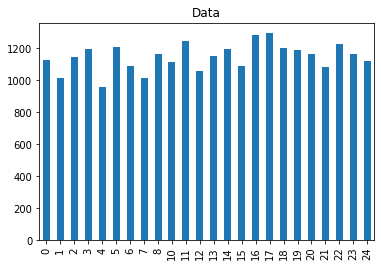

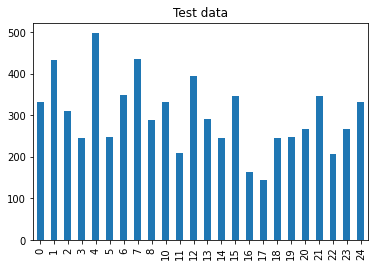

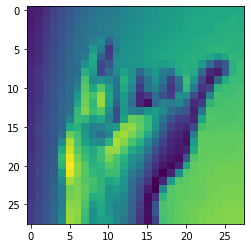

In [2]:
#1. Загрузите данные. Разделите исходный набор данных на обучающую и валидационную выборки.

data = pd.read_csv("./data/sign_mnist_train.csv")
test_data = pd.read_csv("./data/sign_mnist_test.csv")

data["label"].value_counts().sort_index().plot.bar()
plt.title("Data")
plt.show()

test_data["label"].value_counts().sort_index().plot.bar()
plt.title("Test data")
plt.show()

random_img = data.iloc[:,1:].sample(n=1).to_numpy().reshape(28, 28)
plt.imshow(random_img)
plt.show()

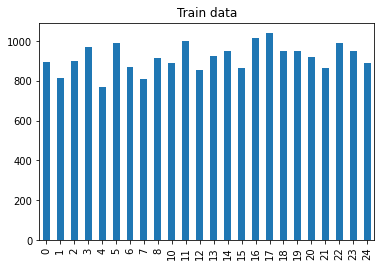

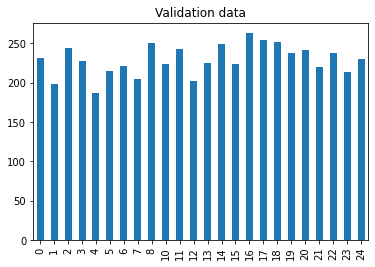

In [3]:
train_data, valid_data = train_test_split(data, test_size=0.2, random_state=39)

train_data = train_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)

train_data["label"].value_counts().sort_index().plot.bar()
plt.title("Train data")
plt.show()

valid_data["label"].value_counts().sort_index().plot.bar()
plt.title("Validation data")
plt.show()

In [4]:
X_train = train_data.iloc[:, 1:].to_numpy().reshape(-1, 28, 28, 1)
Y_train = keras.utils.to_categorical(train_data["label"], num_classes = 25)

X_valid = valid_data.iloc[:, 1:].to_numpy().reshape(-1, 28, 28, 1)
Y_valid = keras.utils.to_categorical(valid_data["label"], num_classes = 25)

X_test = test_data.iloc[:, 1:].to_numpy().reshape(-1, 28, 28, 1)
Y_test = test_data["label"]

valid_generator = ImageDataGenerator(rescale=1/255).flow(X_valid, Y_valid, batch_size=BATCH_SIZE)
test_generator = ImageDataGenerator(rescale=1/255).flow(X_test, batch_size=BATCH_SIZE, shuffle=False)

In [5]:
#2. Реализуйте глубокую нейронную сеть со сверточными слоями. Какое качество классификации получено? Какая архитектура сети была использована?

def get_model():
    model = keras.models.Sequential()

    model.add(Conv2D(6, (3, 3), activation=keras.activations.relu, input_shape=(28, 28, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(16, (3, 3), activation=keras.activations.relu))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(120, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(84, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(25, activation='softmax'))

    model.compile(loss="categorical_crossentropy", metrics=["accuracy"])

    model.summary()
    return model

def check_accuracy(model, test_generator, Y_test):
    predict = model.predict(test_generator, steps=np.ceil(Y_test.shape[0]/BATCH_SIZE))
    labels = np.argmax(predict, axis=-1)
    print("Список предсказанных значений: ", np.unique(labels, return_counts=True)[0])
    print("Точность:", metrics.accuracy_score(Y_test, labels))
    print("F1 взвешенная с учетом дисбаланса:", metrics.f1_score(Y_test, labels, average="weighted"))

callbacks = [EarlyStopping(patience=10)]

In [6]:
train_generator = ImageDataGenerator(rescale=1/255).flow(X_train, Y_train, batch_size=BATCH_SIZE)
model = get_model()
model.fit(train_generator, epochs=EPOCHS, validation_data=valid_generator,
                    validation_steps=valid_data.shape[0]//BATCH_SIZE, steps_per_epoch=train_data.shape[0]//BATCH_SIZE,
                    callbacks=callbacks)

check_accuracy(model, test_generator, Y_test)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 6)         60        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 16)        880       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 400)               0         
_________________________________________________________________
dense (Dense)                (None, 120)               48120     
_________________________________________________________________
dropout (Dropout)            (None, 120)               0

In [7]:
#3. Примените дополнение данных (data augmentation). Как это повлияло на качество классификатора?

train_generator = ImageDataGenerator(rescale=1/255,
                                     rotation_range=5,
                                     zoom_range=0.1,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1)\
    .flow(X_train, Y_train, batch_size=BATCH_SIZE)
model = get_model()

model.fit(train_generator, epochs=EPOCHS, validation_data=valid_generator,
                    validation_steps=valid_data.shape[0]//BATCH_SIZE, steps_per_epoch=train_data.shape[0]//BATCH_SIZE,
                    callbacks=callbacks)

check_accuracy(model, test_generator, Y_test)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 6)         60        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 6)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 16)        880       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 120)               48120     
_________________________________________________________________
dropout_2 (Dropout)          (None, 120)              

In [47]:
#4. Поэкспериментируйте с готовыми нейронными сетями (например, AlexNet, VGG16, Inception и т.п.), применив передаточное обучение. Как это повлияло на качество классификатора? Можно ли было обойтись без него? Какой максимальный результат удалось получить на контрольной выборке?

def get_model():
    model = vgg16.VGG16(include_top=False, input_shape=(32, 32, 3))
    for layer in model.layers:
	    layer.trainable = False

    flatten = Flatten()(model.layers[-1].output)
    dense = Dense(128, activation='relu')(flatten)
    out = Dense(25, activation='softmax')(dense)
    model = keras.models.Model(inputs=model.inputs, outputs=out)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"])

    return model

def transform(data):
    transformed = data
    zeros = np.zeros((data.shape[0], 28, 2, 1))
    transformed = np.concatenate([zeros, transformed, zeros], axis=2)

    zeros = np.zeros((data.shape[0], 2, 32, 1))
    transformed = np.concatenate([zeros, transformed, zeros], axis=1)

    transformed = np.concatenate([transformed, transformed, transformed], axis=3)
    return transformed

model = get_model()
train_generator = ImageDataGenerator(rescale=1/255,
                                     rotation_range=5,
                                     zoom_range=0.1,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1)\
    .flow(transform(X_train), Y_train, batch_size=BATCH_SIZE)
valid_generator = ImageDataGenerator(rescale=1/255).flow(transform(X_valid), Y_valid, batch_size=BATCH_SIZE)
test_generator = ImageDataGenerator(rescale=1/255).flow(transform(X_test), batch_size=BATCH_SIZE, shuffle=False)


model.fit(train_generator, epochs=EPOCHS, validation_data=valid_generator,
                    validation_steps=valid_data.shape[0]//BATCH_SIZE, steps_per_epoch=train_data.shape[0]//BATCH_SIZE,
                    callbacks=callbacks)

check_accuracy(model, test_generator, Y_test)




Epoch 1/50
439/439 [==============================] - 7s 15ms/step - loss: 2.2448 - accuracy: 0.3556 - val_loss: 1.4897 - val_accuracy: 0.5139